# Where is the Most Isolated City in the World?
A little data analysis to answer the question of where is the most isolated citiy in the world.

What is a *city*? Great question. Here I consider it to be a *metropolitan area* or *urban agglomeration* that has a population over five hundred thousand people. Going with metropolitan area to avoid arbitary administrative area defintions or customs. For example, major cities in Australia tend to have very small formal *city* council areas, typically covering ten percent or less of the metropolitan area population. In the United States, the formal city area tends to be much larger, covering a much greater proportion of the population. Using a *metropolitan area* is an attempt to capture populated areas that function as congruous economic areas.

As for the population cutoff of a *major* city, that is something up for debate. It lays somewhere between one hundred thousand and ten million. Where exactly, depends largely upon perspective. I've chosen five hundred thousand, as I think a *major* city is somewhere between one hundred thousand and a million.

## 1. Data Collection
Source of data can be found at [United Nations, World Urbanization Prospects 2018](https://population.un.org/wup/Download/) under "Urban Agglomerations", "File 22: Annual Population of Urban Agglomerations with 300,000 Inhabitants or More in 2018, by country, 1950-2035 (thousands)".

Did look at using [geonames data](https://www.geonames.org/), however only found data for "populated places" and did not find any for urban agglomerations aka metropolitan areas.

In [1]:
import urllib.request
import pathlib
import numpy as np
import pandas as pd

# Set up file name, file path, url and download data
fn = 'WUP2018-F22-Cities_Over_300K_Annual.xls'
fp = pathlib.Path('../data/' + fn)

url = 'https://population.un.org/wup/Download/Files/'
url += fn
with urllib.request.urlopen(url) as response:
    data = response.read()    
    with open(fp, "wb") as f:
        f.write(data)

# Read in data
df = pd.read_excel(fp,
                   sheet_name='Data',
                   header=16,
                   index_col=0)

popn_yr = 2018 # Going to use data for year 2018
keep_cols = ['Country Code',
             'Country or area',
             'City Code',
             'Urban Agglomeration',
             'Latitude',
             'Longitude',
             popn_yr]
df = df.loc[:, df.columns.isin(keep_cols)]

col_rename = {'Country Code': 'country_code',
             'Country or area': 'country_name',
             'City Code': 'city_code',
             'Urban Agglomeration': 'city_name',
             'Latitude': 'lat',
             'Longitude': 'lon',
             2018: 'popn'}
df = df.rename(columns=col_rename)
df['popn'] = round(df['popn']*1000, 0)

col_dtypes = {'country_code': np.int32,
             'country_name': str,
             'city_code': np.int32,
             'city_name': str,
             'lat': np.float32,
             'lon': np.float32,
             'popn': np.int32}
df = df.astype(col_dtypes)

#### Population cutoff definition

In [2]:
min_popn = 500*10**3

#### Formatting helpers

In [3]:
from IPython.display import display

# For setting column widths
max_city_name_len = df['city_name'].apply(lambda x: len(str(x))).max()
max_country_name_len = df['country_name'].apply(lambda x: len(str(x))).max()
max_popn_len = df['popn'].apply(lambda x: len(str(x))).max()

# Formats
text_col_names = r"City|Country"
text_cells_fmt = {'text-align': 'left'}
city_name_width = {'width': f'{max_city_name_len/2}em'}
country_name_width = {'width': f'{max_country_name_len/2}em'}
popn_width = {'width': f'{max_popn_len*1.1}em'}

# Quick function to display formatted data frame
def display_df(ddf, df_caption):
    display(
        ddf.style\
            .set_caption(df_caption)\
            .format(thousands=",", precision=0,
                    formatter={('W.Avg. Distance(log_10[km])'): "{:.2f}"})\
            .set_properties(
                subset=ddf.columns[ddf.columns.str.contains(text_col_names)],
                **text_cells_fmt)\
            .set_properties(
                subset=ddf.columns[ddf.columns.str.contains("City")],
                **city_name_width)\
            .set_properties(
                subset=ddf.columns[ddf.columns.str.contains("Country")],
                **country_name_width)\
            .set_properties(
                subset=ddf.columns[ddf.columns.str.contains("Population")],
                **popn_width)\
            .set_table_styles(
                [dict(selector='th', props=[('text-align', 'left')]),
                dict(selector='caption',
                    props=[('text-align', 'left'),
                            ('font-size', '125%'),
                            ('line-height', '2.0')])])\
            .hide(axis='index')
        )

### 1.1 Some Quick Data Demographics

In [4]:
from IPython.display import Markdown

disp_str = f"The data contains {len(df):,.0f} cities " +\
      f"covering a total population of {sum(df['popn']):,.0f} people"
display(Markdown(disp_str))

print_cols = ['city_name',
              'country_name',
              'popn']

print_cols_rename = {'city_name': 'City Name',
                    'country_name': 'Country Name',
                    'popn': 'Population'}

table_caption = "The Smallest Cities in the Data"
display_df(df[print_cols].\
    sort_values(['popn']).\
        rename(columns=print_cols_rename).\
            head(), table_caption)

table_caption = "The Largest Cities in the Data"
display_df(df[print_cols].\
    sort_values(['popn'], ascending=False).\
        rename(columns=print_cols_rename).\
            head(), table_caption)

The data contains 1,860 cities covering a total population of 2,469,358,215 people

City Name,Country Name,Population
Anning,China,"300,097"
Laredo,United States of America,"300,621"
Yangchun,China,"300,749"
Aguadilla-Isabela-San Sebastian,Puerto Rico,"301,182"
Wollongong,Australia,"301,465"


City Name,Country Name,Population
Tokyo,Japan,"37,468,302"
Delhi,India,"28,513,682"
Shanghai,China,"25,582,138"
São Paulo,Brazil,"21,650,181"
Ciudad de México (Mexico City),Mexico,"21,580,827"


#### And quickly mapping the data

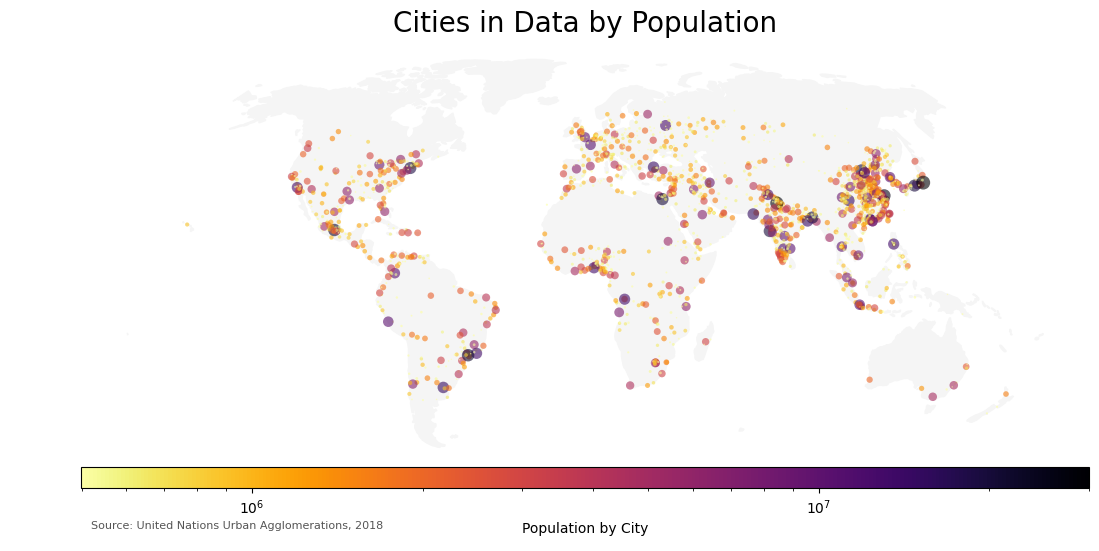

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Coordinate reference systems
wgs84_proj = 'EPSG:4326' # WGS84 projection, typical lat lon style
rob_proj = 'ESRI:54030' # Robinson projection, used for our map

# Setting up the base world map
world_fc = 'whitesmoke' # base color
fig, ax = plt.subplots(figsize=(13, 6))
gpd_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gpd_world = gpd_world[gpd_world.name!="Antarctica"]
gpd_world.to_crs(rob_proj, inplace=True)
gpd_world.plot(ax=ax, color=world_fc, edgecolor=world_fc)

# Setting up the city data and geometries
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs=wgs84_proj)
gdf.to_crs(rob_proj, inplace=True)

# Additional axes for the legend
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=-0.0)

# Set up marker sizes based on city size
new_min_ms, new_max_ms = 1*1e0, 1*1e1

gdf['mkr_size'] = np.log10(gdf['popn'])
gdf['mkr_size'] = \
    (gdf['mkr_size'] - gdf['mkr_size'].min()) / np.ptp(gdf['mkr_size']) \
            * (new_max_ms - new_min_ms) + new_min_ms
gdf['mkr_size'] = gdf['mkr_size']**2

# Plotting the cities
gdf.plot(column='popn',
         ax=ax, cax=cax,
         marker='o',
         markersize='mkr_size',
         legend=True,
         legend_kwds={'label': "Population by City",
                      'orientation': 'horizontal'},
         norm=mplcolors.LogNorm(min_popn, vmax=30*1e6),
         alpha=0.6,
         cmap='inferno_r',
         linewidth=0)

# Formatting the plot
ax.set_axis_off()
ax.set_title("Cities in Data by Population",
             fontdict={'fontsize': '20', 'fontweight' : '3'})
_ = ax.annotate("Source: United Nations Urban Agglomerations, 2018",
            xy=(0.07, .05),
            xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=8,
            color='#555555')

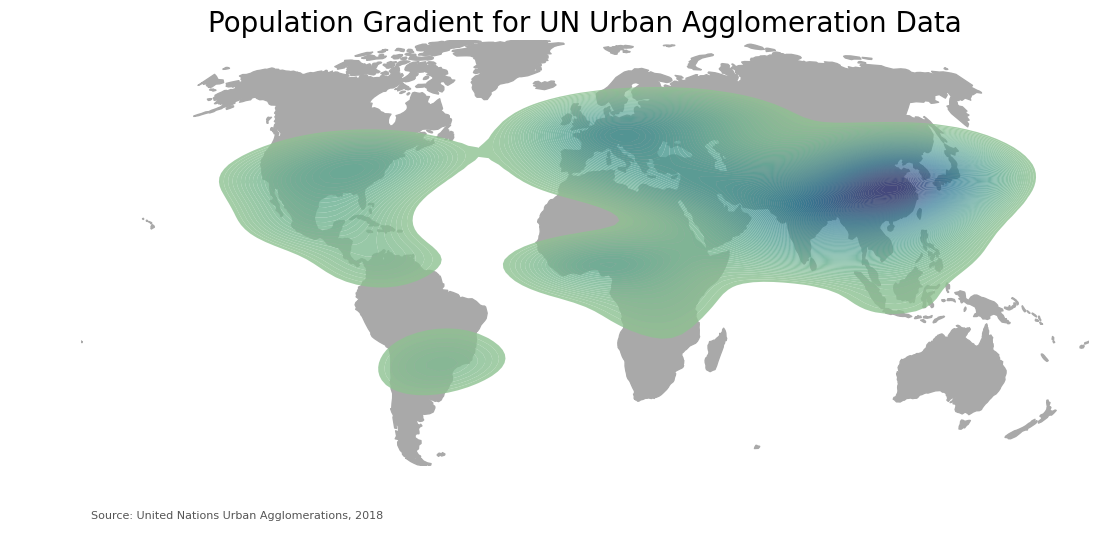

In [6]:
import seaborn as sns
import scipy

# Set up the base map
fig, ax = plt.subplots(figsize=(13, 6))

world_fc_dark = 'darkgrey'
gpd_world.plot(ax=ax, color=world_fc_dark, edgecolor=world_fc_dark)
axis = gpd_world.total_bounds

# Set up the data frame to use
df_hm = df.loc[:, ['lat', 'lon', 'popn']]
df_hm = gpd.GeoDataFrame(
    df_hm,
    geometry=gpd.points_from_xy(df_hm['lon'], df_hm['lat']),
    crs=wgs84_proj)
df_hm.to_crs(crs=rob_proj, inplace=True)
df_hm['lon_gm'] = df_hm.geometry.x
df_hm['lat_gm'] = df_hm.geometry.y
df_hm['popn'] = np.log10(df_hm['popn'])

# Calculate the KDE
data = np.c_[df_hm.lon_gm, df_hm.lat_gm]
kde = scipy.stats.gaussian_kde(data.T, bw_method='scott', weights=df_hm.popn)
data_std = data.std(axis=0, ddof=1)
bw_x = getattr(kde, 'scotts_factor')() * data_std[0]
bw_y = getattr(kde, 'scotts_factor')() * data_std[1]
grid_x = grid_y = 100
x_support = sns.utils._kde_support(data[:, 0], bw_x, grid_x, 3, (axis[0], axis[2]))
y_support = sns.utils._kde_support(data[:, 1], bw_y, grid_y, 3, (axis[1], axis[3]))
xx, yy = np.meshgrid(x_support, y_support)
levels = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)


cset = plt.contourf(
    xx, yy, levels,
    150, # n_levels
    cmap='crest',
    antialiased=True, # avoids lines on the contours to some extent
    alpha=0.80,
)

# Hide lowest N levels
hide_n_lvls = 10
for i in range(0, hide_n_lvls):
    cset.collections[i].set_alpha(0)

# Formatting the plot
ax.set_axis_off()
ax.set_title("Population Gradient for UN Urban Agglomeration Data",
             fontdict={'fontsize': '20', 'fontweight' : '3'})
_ = ax.annotate("Source: United Nations Urban Agglomerations, 2018",
            xy=(0.07, .05),
            xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=8,
            color='#555555')

## 2 Looking at Data for Only *Significant* or *Major* Cities

In [7]:
df = df.loc[df['popn'] > min_popn]
disp_str = f"There are {len(df):,.0f} cities " +\
      f"with a population greater than {min_popn:,.0f} " +\
      f"covering a total population of {sum(df['popn']):,.0f}"
display(Markdown(disp_str))

There are 1,146 cities with a population greater than 500,000 covering a total population of 2,194,683,827

#### Generate all unique pairs of cities

In [8]:
import time
from itertools import combinations
import math

disp_str = f"Generating {math.comb(len(df), 2):,.0f} combinations; " +\
    "this may take a while"
display(Markdown(disp_str))
tic = time.perf_counter()

dist_pairs = pd.DataFrame(
    list(combinations(df.index, 2)),
    columns=['idx_fr', 'idx_to']
    )

toc = time.perf_counter()
disp_str = f"Generated {len(dist_pairs):,.0f} city pairs " +\
      f"in {toc - tic:0.3f} seconds"
display(Markdown(disp_str))

Generating 656,085 combinations; this may take a while

Generated 656,085 city pairs in 0.250 seconds

#### Calculate the distance between each pair
Calculating using the faster, but less accurate great circle distance (`distance.great_circle`) instead of the geodesic distance (using `distance.distance`)

In [9]:
from pandarallel import pandarallel

# Library initialisations
pandarallel.initialize(progress_bar=True)

# Define function for calculating pairs
def calc_dist_pairs(dps):
    # Needs to be 'self-contained' with imports for Windows compatiability
    # see pandarallel package documentation for further details
    from geopy import distance
    
    dps['d_km'] = dps.parallel_apply(
        lambda x: distance.great_circle(
            (x['lat_fr'], x['lon_fr']),
            (x['lat_to'], x['lon_to'])).km, axis=1)

    return dps

# Add lats and longs
dist_pairs = dist_pairs.join(df[['lat', 'lon']], on='idx_fr')
dist_pairs = dist_pairs.join(df[['lat', 'lon']], on='idx_to',
                             lsuffix='_fr', rsuffix='_to')

# Do the distance calculations using parallel processing
tic = time.perf_counter()

dist_pairs = calc_dist_pairs(dist_pairs)

toc = time.perf_counter()
disp_str = f"Calculated distance pairs in {toc - tic:0.3f} seconds"
display(Markdown(disp_str))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Calculated distance pairs in 3.376 seconds

#### Generate all possible permutations i.e. the "upper triangle" and "lower triangle"

In [10]:
d1 = dist_pairs.loc[:, ['d_km', 'idx_to', 'idx_fr']]
d1.rename(columns={'idx_to': 'idx_fr',
                   'idx_fr': 'idx_to'},
          inplace=True,
          errors='raise')
dist_pairs = pd.concat(
    [dist_pairs.loc[:, ['d_km', 'idx_fr', 'idx_to']], d1])

dist_pairs.reset_index(drop=True, inplace=True)

In [11]:
# Quick function to match distance-city_code pairs with city info we
# gathered earlier
def join_pairs_with_city_info(pairs_to_join, city_info):
    df_out = pairs_to_join.join(
        city_info,
        on=['idx_fr'],
        how='left')

    df_out = df_out.join(
        city_info,
        on=['idx_to'],
        how='left',
        lsuffix='_fr',
        rsuffix='_to')
    
    return df_out

#### Now lets look at the calculated distances by examining the results for a few select cities
Set up number of results to print, columns to use etc

In [12]:
print_n = 5

print_cols = ['city_name_fr',
              'country_name_fr',
              'popn_fr',
              'city_name_to',
              'country_name_to',
              'popn_to',
              'd_km']

print_cols_rename = {'city_name_fr': 'City From',
                         'country_name_fr': 'Country From',
                         'popn_fr': 'Population From',
                         'city_name_to': 'City To',
                         'country_name_to': 'Country To',
                         'popn_to': 'Population To',
                         'd_km': 'Distance (km)'}

# Quick function for printing multiple cities
def print_dist_for_city(city_name, pair_dist_data):
    display(Markdown("---"))
    display(Markdown(f"#### **{city_name}**"))

    table_caption = "Smallest Distances"
    
    display_df(
        pair_dist_data.loc[
            pair_dist_data['city_name_fr'] == city_name, print_cols]\
            .sort_values('d_km')\
            .rename(columns=print_cols_rename).head(print_n),
        table_caption)

    table_caption = "Largest Distances"
    
    display_df(
        pair_dist_data.loc[
            pair_dist_data['city_name_fr'] == city_name, print_cols]\
            .sort_values('d_km', ascending=False)\
            .rename(columns=print_cols_rename).head(print_n),
        table_caption)

#### Matching up info for all distance pairs

In [13]:
all_dist = join_pairs_with_city_info(dist_pairs, df)
all_dist = all_dist.loc[all_dist['d_km'] > 0, :]

#### And for a few selected cities

In [14]:
cities = ['Perth', 'New York-Newark', 'Istanbul']
for city in cities:
    print_dist_for_city(city, all_dist)

---

#### **Perth**

City From,Country From,Population From,City To,Country To,Population To,Distance (km)
Perth,Australia,"1,990,745",Adelaide,Australia,"1,320,323","2,132"
Perth,Australia,"1,990,745",Denpasar,Indonesia,"944,292","2,591"
Perth,Australia,"1,990,745",Malang,Indonesia,"871,573","2,686"
Perth,Australia,"1,990,745",Melbourne,Australia,"4,770,894","2,722"
Perth,Australia,"1,990,745",Surabaya,Indonesia,"2,902,504","2,761"


City From,Country From,Population From,City To,Country To,Population To,Distance (km)
Perth,Australia,"1,990,745",Virginia Beach,United States of America,"1,478,105","18,793"
Perth,Australia,"1,990,745",Providence,United States of America,"1,204,673","18,742"
Perth,Australia,"1,990,745",New Haven,United States of America,"590,268","18,714"
Perth,Australia,"1,990,745",Bridgeport-Stamford,United States of America,"952,728","18,711"
Perth,Australia,"1,990,745",Boston,United States of America,"4,307,751","18,707"


---

#### **New York-Newark**

City From,Country From,Population From,City To,Country To,Population To,Distance (km)
New York-Newark,United States of America,"18,819,361",Bridgeport-Stamford,United States of America,"952,728",84
New York-Newark,United States of America,"18,819,361",New Haven,United States of America,"590,268",111
New York-Newark,United States of America,"18,819,361",Allentown-Bethlehem,United States of America,"747,591",125
New York-Newark,United States of America,"18,819,361",Philadelphia,United States of America,"5,695,498",130
New York-Newark,United States of America,"18,819,361",Hartford,United States of America,"990,124",160


City From,Country From,Population From,City To,Country To,Population To,Distance (km)
New York-Newark,United States of America,"18,819,361",Perth,Australia,"1,990,745","18,701"
New York-Newark,United States of America,"18,819,361",Adelaide,Australia,"1,320,323","17,098"
New York-Newark,United States of America,"18,819,361",Melbourne,Australia,"4,770,894","16,672"
New York-Newark,United States of America,"18,819,361",Denpasar,Indonesia,"944,292","16,335"
New York-Newark,United States of America,"18,819,361",Malang,Indonesia,"871,573","16,316"


---

#### **Istanbul**

City From,Country From,Population From,City To,Country To,Population To,Distance (km)
Istanbul,Turkey,"14,750,771",Gebze,Turkey,"692,459",47
Istanbul,Turkey,"14,750,771",Bursa,Turkey,"1,916,489",92
Istanbul,Turkey,"14,750,771",Sakarya,Turkey,"510,450",125
Istanbul,Turkey,"14,750,771",Eskisehir,Turkey,"746,789",191
Istanbul,Turkey,"14,750,771",Izmir,Turkey,"2,936,607",328


City From,Country From,Population From,City To,Country To,Population To,Distance (km)
Istanbul,Turkey,"14,750,771",Auckland,New Zealand,"1,556,875","17,042"
Istanbul,Turkey,"14,750,771",Sydney,Australia,"4,792,281","14,949"
Istanbul,Turkey,"14,750,771",Gold Coast-Tweed Head,Australia,"675,483","14,817"
Istanbul,Turkey,"14,750,771",Brisbane,Australia,"2,338,120","14,753"
Istanbul,Turkey,"14,750,771",Melbourne,Australia,"4,770,894","14,632"


### 2.1 Most Remote City by Using *Simple* Distance
*Simple* distance means the distance from a city to its closest neighbour; we will look at more complex measures later

In [15]:
# Find the minimum distance for any pair that is greater than zero
simple_dist = dist_pairs.loc[dist_pairs['d_km'] > 0, :].reset_index(drop=True)
simple_dist = simple_dist.loc[simple_dist.groupby(['idx_fr'])['d_km'].idxmin()]
simple_dist.reset_index(inplace=True)

# Add back the city information for each distance pair
simple_dist = join_pairs_with_city_info(simple_dist, df)


#### And the results are

In [16]:
table_caption = "The Most Isolated Cities"

display_df(
    simple_dist[print_cols]\
        .sort_values('d_km', ascending=False)\
        .rename(columns=print_cols_rename).head(print_n),
    table_caption)

table_caption = "The Least Isolated Cities"

display_df(
    simple_dist[print_cols]\
        .sort_values('d_km', ascending=True)\
        .rename(columns=print_cols_rename).head(print_n),
    table_caption)

City From,Country From,Population From,City To,Country To,Population To,Distance (km)
Honolulu,United States of America,"879,432",San Francisco-Oakland,United States of America,"3,325,284","3,849"
Auckland,New Zealand,"1,556,875",Sydney,Australia,"4,792,281","2,156"
Perth,Australia,"1,990,745",Adelaide,Australia,"1,320,323","2,132"
Manaus,Brazil,"2,171,314",Belém,Brazil,"2,280,395","1,296"
Antananarivo,Madagascar,"3,058,387",Nampula,Mozambique,"774,682",975


City From,Country From,Population From,City To,Country To,Population To,Distance (km)
Belo Horizonte,Brazil,"5,972,135",Vale do Aço,Brazil,"514,094",2
Vale do Aço,Brazil,"514,094",Belo Horizonte,Brazil,"5,972,135",2
El Paso,United States of America,"927,172",Ciudad Juárez,Mexico,"1,479,737",6
Ciudad Juárez,Mexico,"1,479,737",El Paso,United States of America,"927,172",6
Bucheon,Republic of Korea,"838,903",Incheon,Republic of Korea,"2,763,344",7


#### Mapping the results

In [17]:
map_n = print_n  # Display this number of city pairs

In [18]:
from geographiclib.geodesic import Geodesic

# Function for determining label position and azimuth
def label_posn(lat_fr, lon_fr, lat_to, lon_to, lbl_dist_km=1000, lbl_az=-90):
    # Going to calculate from the most westwards point
    if lon_fr < lon_to:
        lat1 = lat_fr
        lon1 = lon_fr
        lat3 = lat_to
        lon3 = lon_to
    else:
        lat3 = lat_fr
        lon3 = lon_fr
        lat1 = lat_to
        lon1 = lon_to

    # Define the path from 1 to 3
    l_13 = Geodesic.WGS84.InverseLine(lat1, lon1, lat3, lon3)

    # Compute the midpoint i.e. point 2
    p_2 = l_13.Position(0.5 * l_13.s13) # l_13.s13 is distance in metres

    # Define the path from 1 to 2 
    l_12 = Geodesic.WGS84.InverseLine(lat1, lon1, p_2['lat2'], p_2['lon2'])

    # Define the path from 2 to the label position
    l_2lbl = Geodesic.WGS84.DirectLine(
        p_2['lat2'], p_2['lon2'], l_12.azi1 + lbl_az, lbl_dist_km*1e+3)

    # Compute the label position
    p_lbl = l_2lbl.Position(lbl_dist_km*1e+3)
    
    lbl = {'lat': p_lbl['lat2'],
           'lon': p_lbl['lon2'],
           'azi': l_12.azi1}

    return lbl


In [19]:
# Set up data that we are going to map
# First the cities
sd_map = pd.DataFrame(
    columns=['pair', 'fr_to', 'city', 'lat', 'lon', 'popn', 'd_km'])

for idx, row in simple_dist.sort_values('d_km', ascending=False)\
    .head(map_n).reset_index().iterrows():

    sdf = row[['city_name_fr', 'lat_fr', 'lon_fr', 'popn_fr', 'd_km']]
    sdf['fr_to'] = 'fr'
    sdf.rename({'city_name_fr': 'city',
                'lat_fr':'lat',
                'lon_fr':'lon',
                'popn_fr':'popn'}, inplace=True)

    sdt = row[['city_name_to', 'lat_to', 'lon_to', 'popn_to', 'd_km']]
    sdt['fr_to'] = 'to'
    sdt.rename({'city_name_to': 'city',
                'lat_to':'lat',
                'lon_to':'lon',
                'popn_to':'popn'}, inplace=True)

    sd_map = pd.concat([sd_map, sdf.to_frame().T, sdt.to_frame().T],
                       ignore_index=True)
    sd_map = sd_map.fillna(idx)

sd_map = sd_map.astype({'pair': np.int32})


In [20]:
# Next for the line between cities and the line labels showing the distance
from shapely.geometry import LineString

# Form data to map lines between points
line_cols = ['dist_lbl', 'geometry']
line_map = pd.DataFrame(columns=line_cols)

# For the distance labels
dlbl_cols = ['lat', 'lon', 'azi', 'lbl']
dlbl_map = pd.DataFrame(columns=dlbl_cols)
lbl_xtrack = 1000 # in km

for i in range(sd_map['pair'].min(), sd_map['pair'].max() + 1):
    pair_fr = sd_map.loc[(sd_map['pair']==i) & (sd_map['fr_to']=='fr')]
    pair_to = sd_map.loc[(sd_map['pair']==i) & (sd_map['fr_to']=='to')]
    
    dist_lbl = f"{pair_fr['d_km'].values[0]:,.0f} km"
    
    geo = LineString([(pair_fr['lon'].values[0], pair_fr['lat'].values[0]),
                      (pair_to['lon'].values[0], pair_to['lat'].values[0])])

    line_map = pd.concat(
        [line_map,
         pd.DataFrame([[dist_lbl, geo]], columns=line_cols)],
        ignore_index=True)

    lbl_p = label_posn(pair_fr['lat'].values[0], pair_fr['lon'].values[0],
                       pair_to['lat'].values[0], pair_to['lon'].values[0],
                       lbl_xtrack)

    d1 = pd.DataFrame(lbl_p, columns=['lat', 'lon', 'azi'], index=[i])
    d1['lbl'] = dist_lbl
    dlbl_map = pd.concat([dlbl_map, d1])

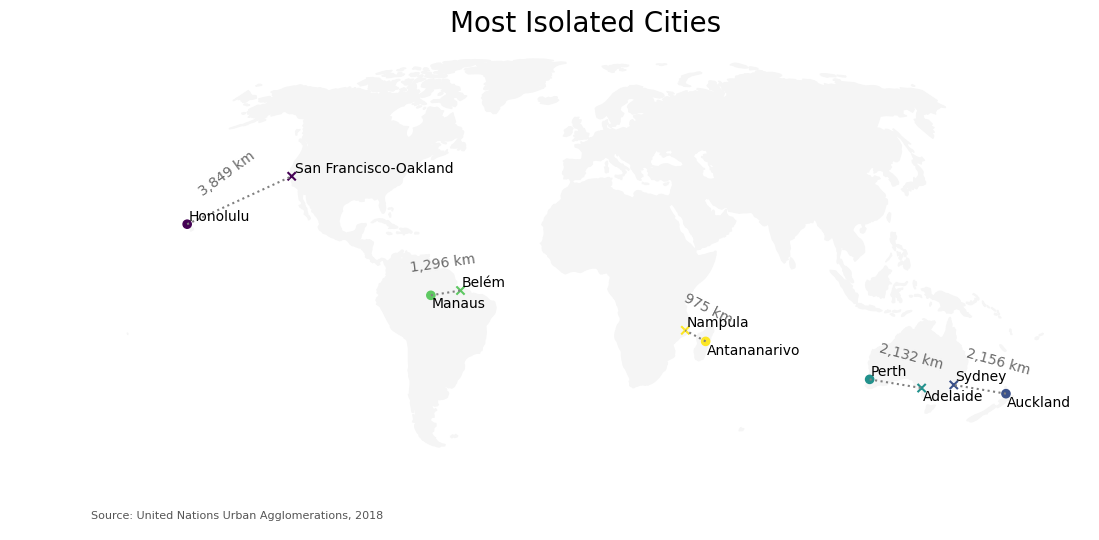

In [21]:
import adjustText as aT

# Setting up the base world map
fig, ax = plt.subplots(figsize=(13, 6))
gpd_world.plot(ax=ax, color=world_fc, edgecolor=world_fc)

# Setting up the city data and geometries
gdf_pts = gpd.GeoDataFrame(
    sd_map,
    geometry=gpd.points_from_xy(sd_map['lon'], sd_map['lat']),
    crs=wgs84_proj)
gdf_pts.to_crs(rob_proj, inplace=True)  

# Plotting the cities
gdf_pts.loc[gdf_pts['fr_to'] == 'fr'].plot(column='pair',
         ax=ax,
         marker='o', markersize=35,
         legend=False)

gdf_pts.loc[gdf_pts['fr_to'] == 'to', :].plot(column='pair',
         ax=ax,
         marker='x', markersize=35,
         legend=False)

# Setting up the line and label data
gdf_line = gpd.GeoDataFrame(
    line_map,
    geometry='geometry',
    crs=wgs84_proj)
gdf_line.to_crs(rob_proj, inplace=True)  

gdf_lbls = gpd.GeoDataFrame(
    dlbl_map,
    geometry=gpd.points_from_xy(dlbl_map['lon'], dlbl_map['lat']),
    crs=wgs84_proj)
gdf_lbls.to_crs(rob_proj, inplace=True)  

# Plotting the lines
gdf_line.plot(ax=ax, color='gray', linestyle=':')

# Labeling of cities
city_lbls = []
for x, y, label in zip(gdf_pts.geometry.x, gdf_pts.geometry.y, gdf_pts['city']):
    city_lbls.append(plt.text(x, y, label, fontsize = 10, color='black'))

aT.adjust_text(city_lbls,
               force_static=(1, 1),
               force_explode=(0.1, 0.1),
               time_lim=1.0)

# Labeling of lines
line_lbls = []
for x, y, azi, label in zip(
    gdf_lbls.geometry.x, gdf_lbls.geometry.y, gdf_lbls['azi'], gdf_lbls['lbl']):
    
    line_lbls.append(
        plt.text(x, y, label,
                        horizontalalignment='center',
                        rotation=90-abs(azi), rotation_mode='anchor',
                        fontsize = 10, color='dimgrey'))

# Formatting the plot
ax.set_axis_off()
ax.set_title("Most Isolated Cities",
             fontdict={'fontsize': '20', 'fontweight' : '3'})
_ = ax.annotate("Source: United Nations Urban Agglomerations, 2018",
            xy=(0.07, .05),
            xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=8,
            color='#555555')

Yeah, so the labels don't exactly line up nicely, likely due to issues with using different coordinate reference systems

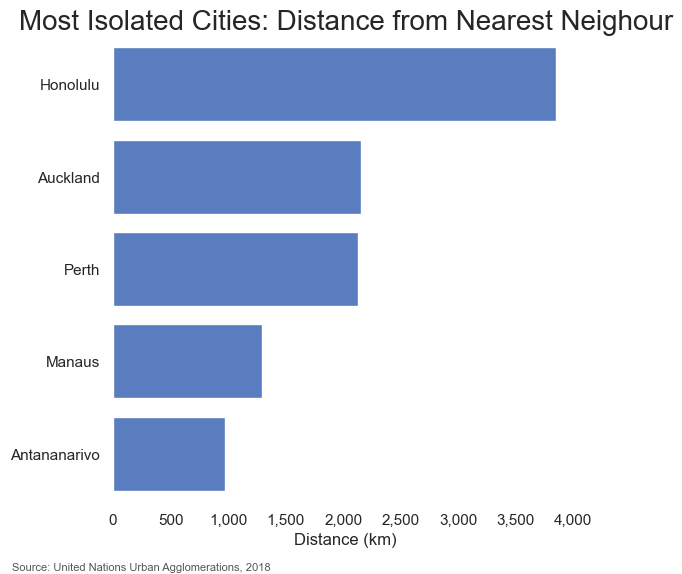

In [22]:
from matplotlib import ticker

sns.set_theme(style='white')

plot_data = simple_dist.sort_values('d_km', ascending=False).head(map_n)

fig, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('muted')
sns.barplot(x='d_km',
            y='city_name_fr',
            data=plot_data,
            color='b')
sns.despine(bottom=True, left=True)

# Formatting the plot
ax.set_title("Most Isolated Cities: Distance from Nearest Neighour",
             fontdict={'fontsize': '20', 'fontweight' : '3'})
_ = ax.annotate("Source: United Nations Urban Agglomerations, 2018",
            xy=(0.02, .02),
            xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=8,
            color='#555555')

ax.set(xlabel="Distance (km)",
       ylabel=None)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))

[Text(0.5, 0, 'Distance (km)'), Text(0, 0.5, 'Population')]

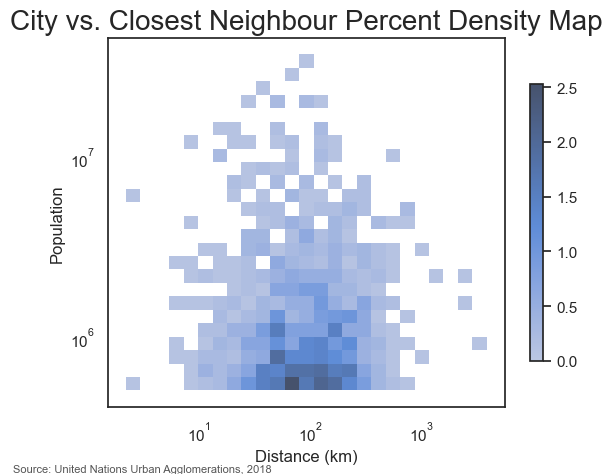

In [23]:
ax = sns.histplot(data=simple_dist, x='d_km', y='popn_fr', 
             bins=25, stat='percent',
             log_scale=(True, True), cbar=True, cbar_kws=dict(shrink=.75))

# Formatting the plot
ax.set_title("City vs. Closest Neighbour Percent Density Map",
             fontdict={'fontsize': '20', 'fontweight' : '3'})
_ = ax.annotate("Source: United Nations Urban Agglomerations, 2018",
            xy=(0.02, .02),
            xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=8,
            color='#555555')
ax.set(xlabel="Distance (km)",
       ylabel="Population")

So peak for cities with less than a million people, with nearest neighour approxmiately 100 km away.

### 2.2 Using Population Weighted Averages
The idea here is that isolate is not just the distance to the nearest neighbour, but the average population weighted distance to everyone else on the Earth. Will first use the arithmetic mean, then use the geometric mean.

Defining a function to calculated the weighted averages

In [24]:
def calc_wavgs(dps, dist_col, city_info):
    # Table of distances between each city
    dist_pairs_table = dps.pivot_table(values=dist_col,
                                       index='idx_fr',
                                       columns='idx_to',
                                       fill_value=0,
                                       sort=False)

    # Matrix multiply with populations and divide by total population to give
    # the population weighted average
    w_avgs = (dist_pairs_table @ city_info['popn']).\
        div(sum(city_info['popn']))

    w_avgs.rename('w_avgs', inplace=True, errors='raise')

    # And join back up with the city info
    w_avgs = city_info.join(w_avgs, how='right', rsuffix='w_avgs')

    return w_avgs

#### Using the arithmetic weighted average

In [25]:
print_cols = ['city_name',
              'country_name',
              'popn',
              'w_avgs']

print_cols_rename = {'city_name': 'City',
                     'country_name': 'Country',
                     'popn': 'Population',
                     'w_avgs': 'Weighted Avg. Distance (km)'}

arith_wavgs = calc_wavgs(dist_pairs, 'd_km', df)

table_caption = "The Most Isolated Cities"

display_df(
    arith_wavgs[print_cols]\
        .sort_values('w_avgs', ascending=False)\
        .rename(columns=print_cols_rename).head(print_n),
    table_caption)

table_caption = "The Least Isolated Cities"

display_df(
    arith_wavgs[print_cols]\
        .sort_values('w_avgs', ascending=True)\
        .rename(columns=print_cols_rename).head(print_n),
    table_caption)

City,Country,Population,Weighted Avg. Distance (km)
Concepción,Chile,"857,336","13,665"
Valparaíso,Chile,"966,531","13,594"
Santiago,Chile,"6,680,371","13,584"
Mendoza,Argentina,"1,133,373","13,539"
San Juan,Argentina,"528,495","13,504"


City,Country,Population,Weighted Avg. Distance (km)
Almaty,Kazakhstan,"1,829,005","6,135"
Bishkek,Kyrgyzstan,"996,319","6,136"
Namangan,Uzbekistan,"513,439","6,140"
Kuerle,China,"678,107","6,148"
Shimkent,Kazakhstan,"982,240","6,150"


#### Using the geometric weighted average
Using `log(distance)` based on the idea that the relative magnitude of distance is what matters, not the absolute amount. In theory, isolation is probably more often thought about in terms of time taken to travel, but that metric is rather difficult to gather for each city in the data.

In [26]:
print_cols = ['city_name',
              'country_name',
              'popn',
              'log_w_avgs',
              'w_avgs']

print_cols_rename = {'city_name': 'City',
                     'country_name': 'Country',
                     'popn': 'Population',
                     'log_w_avgs': 'W.Avg. Distance(log_10[km])',
                     'w_avgs': 'W.Avg. Distance (km)'}

# Add one to distance so that log(distance) = 0 on diagonals
dist_pairs['log_d_km'] = np.log10(dist_pairs['d_km'] + 1)
geo_wavgs = calc_wavgs(dist_pairs, 'log_d_km', df)

geo_wavgs['log_w_avgs'] = geo_wavgs['w_avgs']
geo_wavgs['w_avgs'] = 10**(geo_wavgs['w_avgs'])

table_caption = "The Most Isolated Cities"

display_df(
    geo_wavgs[print_cols]\
        .sort_values('w_avgs', ascending=False)\
        .rename(columns=print_cols_rename).head(print_n),
    table_caption)

table_caption = "The Least Isolated Cities"

display_df(
    geo_wavgs[print_cols]\
        .sort_values('w_avgs', ascending=True)\
        .rename(columns=print_cols_rename).head(print_n),
    table_caption)

City,Country,Population,W.Avg. Distance(log_10[km]),W.Avg. Distance (km)
Concepción,Chile,"857,336",4.09,"12,165"
Valparaíso,Chile,"966,531",4.08,"11,907"
Mendoza,Argentina,"1,133,373",4.07,"11,800"
San Juan,Argentina,"528,495",4.07,"11,765"
Auckland,New Zealand,"1,556,875",4.07,"11,754"


City,Country,Population,W.Avg. Distance(log_10[km]),W.Avg. Distance (km)
Shanghai,China,"25,582,138",3.59,"3,883"
"Nanjing, Jiangsu",China,"8,244,627",3.59,"3,910"
Hefei,China,"3,979,854",3.60,"3,951"
Wuhan,China,"8,175,602",3.60,"3,954"
"Suzhou, Jiangsu",China,"6,338,509",3.60,"3,954"
